In [ ]:
import sys
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision import transforms, datasets

In [ ]:
def load_db(root='/tmp/', batch_size=64, shuffle=True, valid_ratio=0.2):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
  trainset = datasets.MNIST(root, train=True, download=True, transform = transform)
  testset = datasets.MNIST(root, train=False, download=True, transform = transform)
  if valid_ratio > 0:
    # # divide the training set into validation and training set.
    instance_num = len(trainset)
    indices = list(range(instance_num))
    split_pt = int(instance_num * valid_ratio)
    train_idx, valid_idx = indices[split_pt:], indices[:split_pt]
    train_sampler, valid_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(valid_idx)
    train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
  else:
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=shuffle)
    valid_loader = None

  test_loader = DataLoader(testset, batch_size=batch_size, shuffle=shuffle)
  image_size, n_classes, channels_in = 28, 10, 1
  return train_loader, valid_loader, test_loader, image_size, n_classes, channels_in

In [ ]:
class CCP(nn.Module):
    def __init__(self, hidden_size, image_size=28, channels_in=1, n_degree=4, bias=False, n_classes=10):
        super(CCP, self).__init__()
        self.image_size = image_size
        self.channels_in = channels_in
        self.total_image_size = self.image_size * self.image_size * channels_in
        self.hidden_size = hidden_size
        self.n_classes = n_classes
        self.n_degree = n_degree
        for i in range(1, self.n_degree + 1):
            setattr(self, 'U{}'.format(i), nn.Linear(self.total_image_size, self.hidden_size, bias=bias))
        self.C = nn.Linear(self.hidden_size, self.n_classes, bias=True)

    def forward(self, z):
        h = z.view(-1, self.total_image_size)
        out = self.U1(h)
        for i in range(2, self.n_degree + 1):
            out = getattr(self, 'U{}'.format(i))(h) * out + out
        out = self.C(out)
        return out

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1 and classname != 'CCP_Conv' and classname != 'NCP_Conv':
            m.weight.data.normal_(0.0, 0.01)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)
        # print('initializing {}'.format(classname))

train_loader, valid_loader, test_loader, image_size, n_classes, channels_in = load_db(batch_size=64)
# create the model.
net = CCP(16, image_size=image_size, n_classes=n_classes)
net.apply(net.weights_init)
# # define the optimizer.
opt = optim.SGD(net.parameters(), lr=0.001)
# # aggregate losses and accuracy.
train_losses, acc_list = [], []

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
criterion = torch.nn.CrossEntropyLoss().to(device)
net = net.to(device)

def train(train_loader, net, optimizer, criterion, epoch, device):
    """ Perform single epoch of the training."""
    net.train()
    train_loss, correct, total = 0, 0, 0
    for idx, data_dict in enumerate(train_loader):
        img = data_dict[0]
        label = data_dict[1]
        inputs, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        pred = net(inputs)
        loss = criterion(pred, label)
        assert not torch.isnan(loss), 'NaN loss.'
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(pred.data, 1)
        total += label.size(0)
        correct += predicted.eq(label).cpu().sum()
        if idx % 100 == 0 and idx > 0:

            acc = float(correct) / total
            m2 = ('Epoch: {}, Epoch iters: {} / {}\t'
                  'Loss: {:.04f}, Acc: {:.06f}')
            print(m2.format(epoch, idx, len(train_loader), float(train_loss), acc))
    return train_loss

def test(net, test_loader, device='cuda'):
    """ Perform testing, i.e. run net on test_loader data
        and return the accuracy. """
    net.eval()
    correct, total = 0, 0
    for (idx, data) in enumerate(test_loader):
        sys.stdout.write('\r [%d/%d]' % (idx + 1, len(test_loader)))
        sys.stdout.flush()
        img = data[0].to(device)
        label = data[1].to(device)
        with torch.no_grad():
             pred = net(img)
        _, predicted = pred.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()
    return correct / total

acc = 0.
for epoch in range(0, 5):
    print('Epoch {} (previous validation accuracy: {:.03f})'.format(epoch, acc))
    loss_tr = train(train_loader, net, opt, criterion, epoch, device)
    acc = test(net, valid_loader, device=device)
    train_losses.append(loss_tr)
    acc_list.append(acc)

Epoch 0 (previous validation accuracy: 0.000)
Epoch: 0, Epoch iters: 100 / 750	Loss: 206.1170, Acc: 0.277692
Epoch: 0, Epoch iters: 200 / 750	Loss: 322.6100, Acc: 0.443252
Epoch: 0, Epoch iters: 300 / 750	Loss: 398.6233, Acc: 0.548328
Epoch: 0, Epoch iters: 400 / 750	Loss: 458.1429, Acc: 0.614168
Epoch: 0, Epoch iters: 500 / 750	Loss: 510.8598, Acc: 0.659649
Epoch: 0, Epoch iters: 600 / 750	Loss: 557.9363, Acc: 0.692128
Epoch: 0, Epoch iters: 700 / 750	Loss: 601.8254, Acc: 0.717101
 [188/188]Epoch 1 (previous validation accuracy: 0.866)
Epoch: 1, Epoch iters: 100 / 750	Loss: 39.8433, Acc: 0.876392
Epoch: 1, Epoch iters: 200 / 750	Loss: 79.1471, Acc: 0.878809
Epoch: 1, Epoch iters: 300 / 750	Loss: 116.4998, Acc: 0.882371
Epoch: 1, Epoch iters: 400 / 750	Loss: 151.7426, Acc: 0.885365
Epoch: 1, Epoch iters: 500 / 750	Loss: 188.8023, Acc: 0.886290
Epoch: 1, Epoch iters: 600 / 750	Loss: 222.6400, Acc: 0.888779
Epoch: 1, Epoch iters: 700 / 750	Loss: 256.3597, Acc: 0.890135
 [188/188]Epoch 2 

Text(0.5, 1.0, 'Validation accuracy')

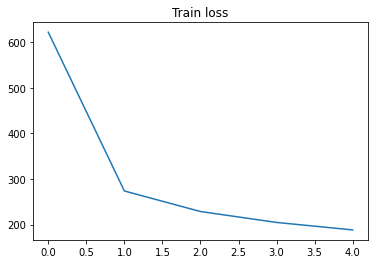

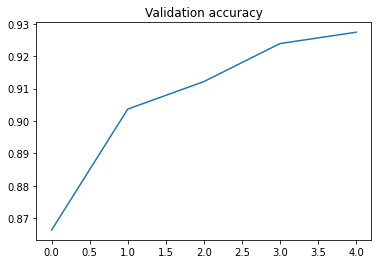

In [ ]:
%matplotlib inline
plt.plot(train_losses)
plt.title('Train loss')
plt.figure()
plt.plot(acc_list)
plt.title('Validation accuracy')